In [ ]:
!rm -rf data/
!git clone https://github.com/cse151a-nba-project/data.git

Cloning into 'data'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 48 (delta 19), reused 39 (delta 15), pack-reused 0
Receiving objects: 100% (48/48), 12.00 MiB | 10.72 MiB/s, done.
Resolving deltas: 100% (19/19), done.


In [ ]:
!pip install scikeras

In [ ]:
import pandas as pd
import numpy as np

# 1. Evaluate your (Milestone 3) data, labels and loss function. Were they sufficient or did you have have to change them.

Reference: https://github.com/cse151a-nba-project/milestone-3/blob/main/CSE_151A_Milestone_3.ipynb

Based on our milestone 3 analysis, it seems that the data, labels, and loss function used in the initial linear regression model were sufficient to get a baseline performance, but there is significant room for improvement to reduce the underfitting and high error rates observed.

Data and Labels:
The data consists of advanced player statistics (per, ws_48, usg_percent, bpm, vorp) for the top 8 players of each team from 1990 to 2023. The corresponding labels are the actual team win percentages. This data and label selection appears to be a good starting point, capturing key player performance metrics that could influence team success.

However, as mentioned in the planned improvements, additional feature engineering and selection could enhance the model's performance. This might involve exploring different or additional player statistics, considering interactions between features, or incorporating team-level metrics. Polynomial features could also be introduced to capture nonlinear relationships without immediately switching to more complex models.

Loss Function:
Our analysis uses Mean Squared Error (MSE) as the primary loss function to evaluate the model's performance. MSE is a commonly used loss function for regression problems and is generally well-suited for this task. It penalizes larger errors more heavily, which is appropriate when trying to minimize the difference between predicted and actual win percentages.

Our use of additional evaluation metrics like Mean Absolute Error (MAE) and R-squared (R^2) provides a more comprehensive assessment of the model's performance. MAE gives an interpretable measure of the average absolute difference between predictions and actual values, while R^2 indicates the proportion of variance in the dependent variable (win percentage) that is predictable from the independent variables (player statistics).

In conclusion, while our initial data, labels, and loss function choices were sufficient for establishing a baseline, the high error rates and underfitting suggest that improvements can be made. The planned strategies, such as feature engineering, exploring more complex models (e.g., polynomial regression, deep neural networks), and applying regularization techniques, are explored in this notebook in order to improve our model's performance.



#Milestone 3 code, needed for model building in this milestone

In [ ]:
TOP_X_PLAYERS = 10
INPUT_STATS = ['ts_percent', 'experience', 'x3p_ar', 'per', 'ws_48', 'usg_percent', 'bpm', 'vorp']
INPUT_FEATURE_COUNT = TOP_X_PLAYERS * (len(INPUT_STATS) + 1)
START_YEAR = 1990
END_YEAR = 2023

"""
Extract raw stats of top players in a given year (for either a specific team or all teams).
Uses Advanced.csv file and extracts INPUT_STATS fields.

Output: A tuple containing two elements:
corresp_team_win: A list of (actual) win percentages for the teams included in the analysis.
  (y value that we're trying to predict with our models)
top_list_stats: A NumPy array containing the raw numerical values for the advanced statistics for the top 8 players
of the teams included in the analysis, optionally reshaped based on the INPUT_FEATURE_COUNT for model training.
Without reshaping, it is in the shape of (total teams in year, TOP_X_PLAYERS, INPUT_STATS). Reshaped is (year, INPUT_FEATURE_COUNT).
  (x value that we're using to predict y in our models)
"""
def top_from_team(year, reshape=True, input_team=None):
  advanced_player_data = pd.read_csv("data/Advanced.csv")
  team_data = pd.read_csv("data/Team Summaries.csv")
  team_data = team_data[team_data['season'] == year]
  player_data = pd.read_csv("data/Player Per Game.csv")
  player_data = player_data[player_data['season'] == year]
  top = player_data.sort_values(['tm', 'mp_per_game'], ascending=[True, False])
  teams = top['tm'].unique()

  if (input_team is not None):
    teams = teams[teams == input_team]
    top = top[top['tm'] == input_team]
  else:
    teams = teams[teams != 'TOT']
    top = top[top['tm'] != 'TOT']

  # make a list of the top 8 players from each team, separated by team name
  top_list = []
  top_list_stats = []
  corresp_team_win = []
  i = 0
  for team in teams:

      # get top 8 players
      top_list.append(top[top['tm'] == team].head(TOP_X_PLAYERS)[['seas_id', 'player_id', 'player', 'pos', 'tm', 'mp_per_game']])

      top_list_stats.append(None)

      # calculate win percentage
      temp_team_stats = team_data[team_data['abbreviation'] == team]
      corresp_team_win.append(100 * float(temp_team_stats['w']) / (float(temp_team_stats['w']) + float(temp_team_stats['l'])))

      # do an advanced stats look up for players
      for index, player in top_list[i].iterrows():
        indiv_player_stats = advanced_player_data[advanced_player_data['seas_id'] == player['seas_id']][INPUT_STATS].copy()
        indiv_player_stats['mp_per_game'] = player['mp_per_game']
        indiv_player_stats = indiv_player_stats.to_numpy()
        if (top_list_stats[i] is None):
          top_list_stats[i] = indiv_player_stats
        else:
          top_list_stats[i] = np.concatenate((top_list_stats[i], indiv_player_stats))

      i = i + 1
  top_list_stats = np.array(top_list_stats)
  if (reshape):
    top_list_stats = top_list_stats.reshape(-1, INPUT_FEATURE_COUNT)
  return corresp_team_win, top_list_stats

In [ ]:
all_data_y = None
all_data_x = None

# combining data
for i in range(START_YEAR, END_YEAR + 1):
  # win perc is y, top team players stats is x
  data_y, data_x = top_from_team(i)
  # don't concatenate if empty
  if (all_data_y is None):
    all_data_y = data_y
    all_data_x = data_x
    continue
  all_data_y = np.concatenate((all_data_y, data_y))
  all_data_x = np.concatenate((all_data_x, data_x))

In [ ]:
print(all_data_x.shape)
print(all_data_y.shape)

(993, 90)
(993,)


#2. Train your second model

We decided to train a hyperparameter-tuned elastic net regression model with L1 and L2 regularization, building off of our linear model. This isn't quite a "new" model because it builds off our linear regression model, **so we also have trained a DNN** as part of this milestone as our formal new model for this milestone. Nevertheless, we still added this model because we created it and would like to use it in our performance analysis.

## Original linear regression model, for reference

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(all_data_x, all_data_y, test_size = 0.2, random_state=21)

regressor = LinearRegression().fit(X_train, y_train)

## Hyperparameter-tuned elastic net model

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_x = MinMaxScaler()
scaled_all_data_x = scaler_x.fit_transform(all_data_x)

scaler_y = MinMaxScaler()
scaled_all_data_y = scaler_y.fit_transform(all_data_y.reshape(-1, 1))  # Reshape if necessary

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(scaled_all_data_x, scaled_all_data_y, test_size=0.2, random_state=21)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import make_pipeline

elastic_net_model = make_pipeline(MinMaxScaler(), ElasticNet(random_state=21))

# Parameters grid to search for best parameters
# param_grid = {
#     'elasticnet__alpha': [0.1, 0.5, 1, 5, 10], # Regularization strength
#     'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1] # Mix ratio between Lasso and Ridge, 1 is Lasso, 0 is Ridge
# }
param_grid = {
    'elasticnet__alpha': np.linspace(0.001, 0.02, num=20),
    'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1] # Mix ratio between Lasso and Ridge, 1 is Lasso, 0 is Ridge
}

# Grid search to find best parameters
grid_search = GridSearchCV(elastic_net_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_parameters = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best parameters found: ", best_parameters)

Best parameters found:  {'elasticnet__alpha': 0.004, 'elasticnet__l1_ratio': 0.9}


In [ ]:
# Best parameters from GridSearchCV
best_alpha = best_parameters['elasticnet__alpha']
best_l1_ratio = best_parameters['elasticnet__l1_ratio']

# Setting up the ElasticNet regressor with the best parameters
elastic_net_regressor = make_pipeline(MinMaxScaler(), ElasticNet(alpha=best_alpha, l1_ratio=best_l1_ratio, random_state=21))

# Training the regressor with your training data
elastic_net_regressor.fit(X_train, y_train)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('elasticnet',
                 ElasticNet(alpha=0.004, l1_ratio=0.9, random_state=21))])

## DNN model

In [ ]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV, KFold
from scikeras.wrappers import KerasRegressor

# Define the model function
def create_model(hidden_layers, initial_units, activation):
    model = Sequential()
    model.add(Dense(initial_units, input_dim=X_train.shape[1], activation=activation,
                    kernel_regularizer=l1_l2(0.001)))
    units = initial_units
    for _ in range(hidden_layers - 1):
        units //= 3
        model.add(Dense(units, activation=activation,
                        kernel_regularizer=l1_l2(0.001)))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

# Define the hyperparameters to tune
param_grid = {
    'model__hidden_layers': [3, 4, 5, 6],
    'model__initial_units': [30, 90, 270, 810],
    'model__activation': ['relu', 'tanh'],
    'batch_size': [8, 32]
}

# Create the model wrapper
model = KerasRegressor(model=create_model)

# Define the GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=KFold(n_splits=5, shuffle=True),
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score: ", -grid_search.best_score_)

# Retrieve the best model
best_model = grid_search.best_estimator_

# Set early stopping callback
early_stopping = EarlyStopping(monitor='val_mse', patience=25, restore_best_weights=True)

# Fit the best model with early stopping
history = best_model.fit(X_train, y_train, epochs=500, validation_split=0.2, callbacks=[early_stopping], verbose=0)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


100/100 [==============================] - 2s 9ms/step - loss: 200.4689 - mse: 187.6334
Best parameters found:  {'batch_size': 8, 'model__activation': 'relu', 'model__hidden_layers': 3, 'model__initial_units': 810}
Best score:  57.53814645964669


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get model stats
y_test_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Hyperparameter-tuned Best DNN Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Hyperparameter-tuned Best DNN Model Testing MAE (Mean Absolute Error): {mae}')

25/25 [==============================] - 0s 3ms/step
Hyperparameter-tuned Best DNN Model Testing MSE: 37.071321538895155
Hyperparameter-tuned Best DNN Model Testing MAE (Mean Absolute Error): 4.791809568863584


## A manually tuned DNN model (to show training vs test error)

In [ ]:
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping

# Define the model
manual_model = Sequential([
    Dense(270, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l1_l2(0.001)),  # First hidden layer with regularization
    Dense(90, activation='relu', kernel_regularizer=l1_l2(0.001)),
    Dense(30, activation='relu', kernel_regularizer=l1_l2(0.001)),  # Second hidden layer with regularization
    Dense(1, activation='linear')  # Output layer for regression
])


# Compile the model
manual_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Fit the manually tuned model
history = manual_model.fit(X_train, y_train, epochs=500, batch_size=8, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/500
80/80 [==============================] - 2s 7ms/step - loss: 189.2353 - mse: 183.9901 - val_loss: 52.1131 - val_mse: 47.7165
Epoch 2/500
80/80 [==============================] - 0s 5ms/step - loss: 51.2540 - mse: 47.1278 - val_loss: 40.0027 - val_mse: 36.0223
Epoch 3/500
80/80 [==============================] - 1s 8ms/step - loss: 43.3447 - mse: 39.3961 - val_loss: 53.6962 - val_mse: 49.7837
Epoch 4/500
80/80 [==============================] - 2s 19ms/step - loss: 41.6777 - mse: 37.8001 - val_loss: 47.6406 - val_mse: 43.7966
Epoch 5/500
80/80 [==============================] - 2s 21ms/step - loss: 40.3269 - mse: 36.5107 - val_loss: 46.1721 - val_mse: 42.3758
Epoch 6/500
80/80 [==============================] - 1s 15ms/step - loss: 35.4257 - mse: 31.6548 - val_loss: 55.4853 - val_mse: 51.7370
Epoch 7/500
80/80 [==============================] - 1s 11ms/step - loss: 40.2194 - mse: 36.4850 - val_loss: 38.9878 - val_mse: 35.2712
Epoch 8/500
80/80 [==============================

###DNN model training history visualization

7/7 [==============================] - 0s 3ms/step
Manual DNN Model Testing MSE: 24.68604750231239
Manual DNN Model Testing MAE (Mean Absolute Error): 4.17838261494803


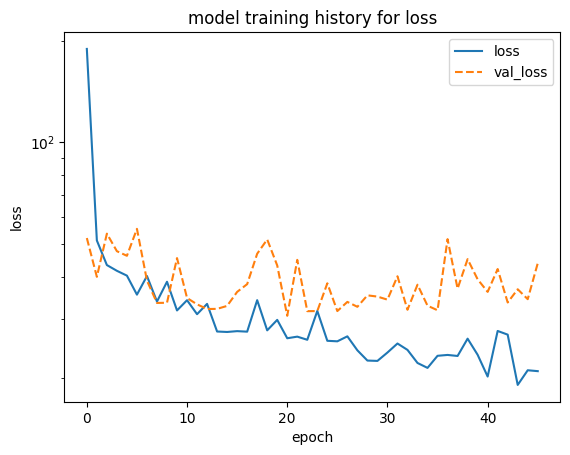

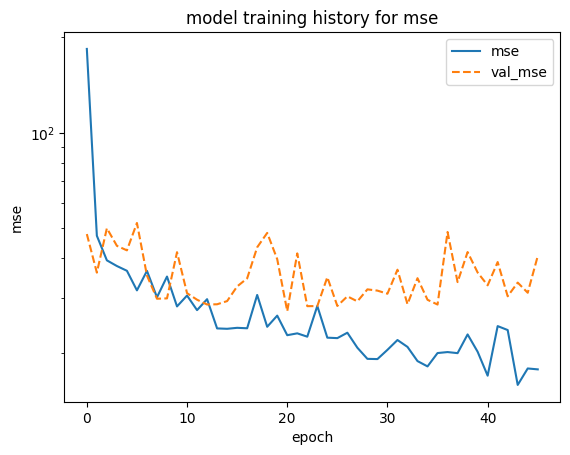

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Get model stats and visualize them
y_test_pred = manual_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_pred)
print(f'Manual DNN Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_pred)
print(f'Manual DNN Model Testing MAE (Mean Absolute Error): {mae}')

metrics = ['loss', 'mse']
for key in metrics:
  plt.figure()
  plt.plot(history.history[key], label=key)
  plt.plot(history.history['val_' + key], '--', label='val_' + key)
  plt.title('model training history for ' + key)
  plt.ylabel(key)
  plt.yscale('log')
  plt.xlabel('epoch')
  plt.legend()


#3. Evaluate your model compare training vs test error

##Improved linear regression model performance, for reference

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 16.704562823490082
Model Training MAE (Mean Absolute Error): 3.2729839541334536
Model Training R^2 (Coeff of Deter.): 0.9312136253734027


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 20.881715559452186
Model Testing MAE (Mean Absolute Error): 3.7103901502672767
Model Testing R^2 (Coeff of Deter.): 0.902803293612228


## Elastic net model performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = elastic_net_regressor.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

Model Training MSE: 17.376403585173943
Model Training MAE (Mean Absolute Error): 3.3292256792705097
Model Training R^2 (Coeff of Deter.): 0.9284471063803035


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = elastic_net_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

Model Testing MSE: 19.921889857702606
Model Testing MAE (Mean Absolute Error): 3.6713894598611754
Model Testing R^2 (Coeff of Deter.): 0.907270929264614


## Hyperparameter-tuned DNN model performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = best_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

100/100 [==============================] - 0s 2ms/step
Model Training MSE: 11.957509295909137
Model Training MAE (Mean Absolute Error): 2.3812739279268493
Model Training R^2 (Coeff of Deter.): 0.9507611349832634


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

25/25 [==============================] - 0s 3ms/step
Model Testing MSE: 37.071321538895155
Model Testing MAE (Mean Absolute Error): 4.791809568863584
Model Testing R^2 (Coeff of Deter.): 0.8274466317308076


## Manually tuned DNN model performance

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_train_predict = manual_model.predict(X_train)
mse = mean_squared_error(y_train, y_train_predict)
print(f'Model Training MSE: {mse}')
mae = mean_absolute_error(y_train, y_train_predict)
print(f'Model Training MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_train, y_train_predict)
print(f'Model Training R^2 (Coeff of Deter.): {r2}')

25/25 [==============================] - 0s 2ms/step
Model Training MSE: 19.95416315281805
Model Training MAE (Mean Absolute Error): 3.521449744918063
Model Training R^2 (Coeff of Deter.): 0.9178323577519873


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_predict = manual_model.predict(X_test)
mse = mean_squared_error(y_test, y_test_predict)
print(f'Model Testing MSE: {mse}')
mae = mean_absolute_error(y_test, y_test_predict)
print(f'Model Testing MAE (Mean Absolute Error): {mae}')
r2 = r2_score(y_test, y_test_predict)
print(f'Model Testing R^2 (Coeff of Deter.): {r2}')

7/7 [==============================] - 0s 2ms/step
Model Testing MSE: 24.68604750231239
Model Testing MAE (Mean Absolute Error): 4.17838261494803
Model Testing R^2 (Coeff of Deter.): 0.8850955275142252


## Visualization: Team Win Percentage Distribution (Predicted vs. Acutal)

Elastic net model MSE: 16.61714609398939
Linear regression model MSE: 16.01094913155602
1/1 [==============================] - 0s 34ms/step
Manual DNN MSE: 13.8863375647462
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN MSE: 5.959423411149853


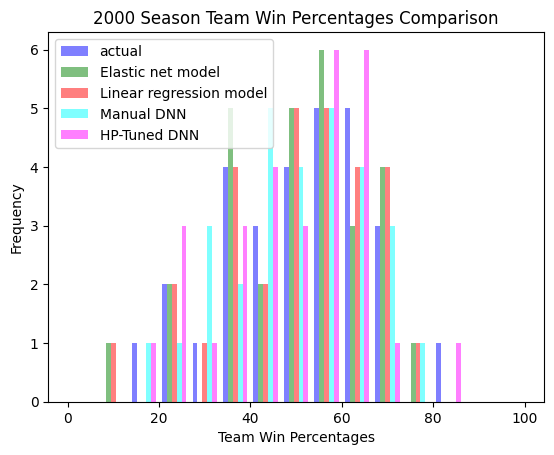

Elastic net model MSE: 9.658103213283072
Linear regression model MSE: 11.001768117992187
1/1 [==============================] - 0s 27ms/step
Manual DNN MSE: 14.957053521996729
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN MSE: 23.74826422676734


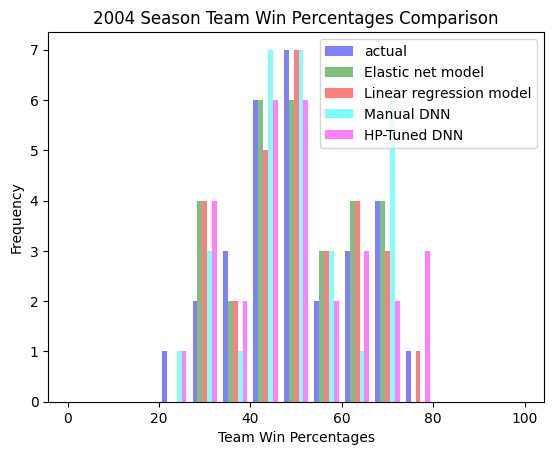

Elastic net model MSE: 13.674531310080596
Linear regression model MSE: 14.068617893002388
1/1 [==============================] - 0s 25ms/step
Manual DNN MSE: 16.415460093662496
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN MSE: 10.934496559061474


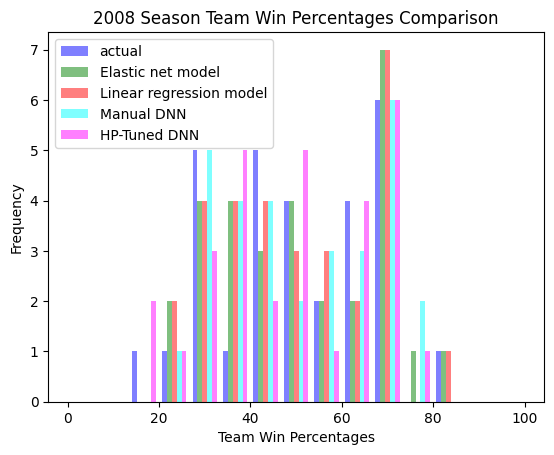

Elastic net model MSE: 16.081028413380626
Linear regression model MSE: 15.950830632909698
1/1 [==============================] - 0s 25ms/step
Manual DNN MSE: 24.297075183992344
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN MSE: 25.496339744827957


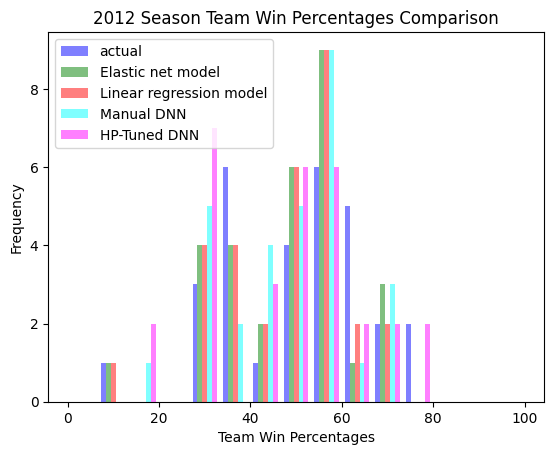

Elastic net model MSE: 13.399156478368003
Linear regression model MSE: 15.245535825122204
1/1 [==============================] - 0s 28ms/step
Manual DNN MSE: 17.76212756885221
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN MSE: 16.731120247517943


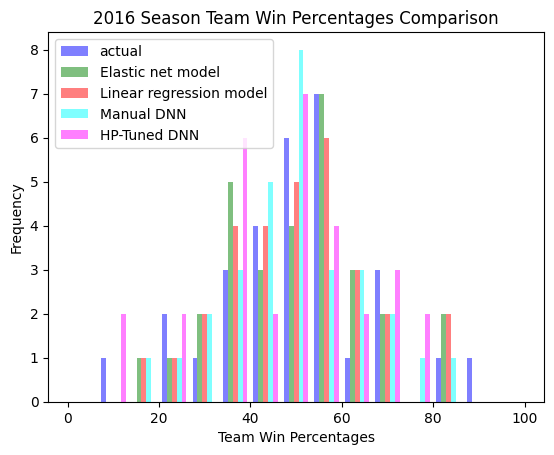

Elastic net model MSE: 22.842012243628936
Linear regression model MSE: 22.089408105904145
1/1 [==============================] - 0s 29ms/step
Manual DNN MSE: 30.590197212902478
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN MSE: 25.421498259141053


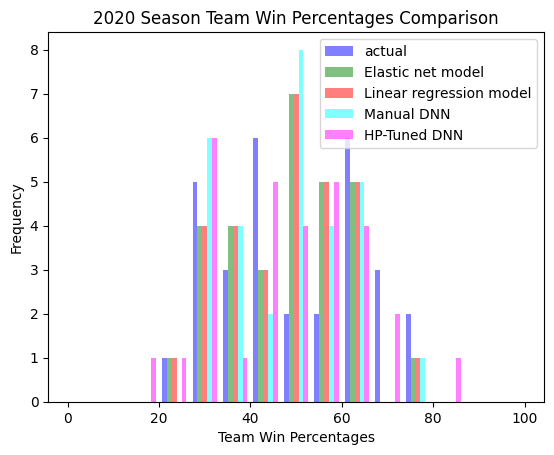

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

def plot_win_dist_predict_vs_actual(year, models):
    year_win, year_stats = top_from_team(year)  # Assuming this fetches actual win percentages and stats for the year

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # Extend as needed
    color_index = 0
    predictions = [year_win]

    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        mse = mean_squared_error(year_win, year_predicted)
        predictions.append(year_predicted)
        print(f'{model_name} MSE: {mse}')

    # Plot predicted win percentages for each model
    plt.hist(predictions, range=[0, 100], alpha=0.5, bins=15, label=['actual'] + list(models.keys()), color=colors[:len(predictions)])

    plt.legend(loc='best')
    plt.xlabel('Team Win Percentages')
    plt.ylabel('Frequency')
    plt.title(f'{year} Season Team Win Percentages Comparison')

    # Display the plot
    plt.show()

def plot_win_dist_predict_vs_actual_plots(models):
    START_YEAR = 2000
    END_YEAR = 2020

    for i in range(START_YEAR, END_YEAR + 1, 4):
        plot_win_dist_predict_vs_actual(i, models)

plot_win_dist_predict_vs_actual_plots({'Elastic net model': elastic_net_regressor, 'Linear regression model': regressor, 'Manual DNN': manual_model, 'HP-Tuned DNN': best_model})


## Visualization: Team Percentage Residual Error  (Predicted vs. Acutal)

Elastic net model 2000 Actual vs. Predicted MSE: 16.61714609398939
Linear regression model 2000 Actual vs. Predicted MSE: 16.01094913155602
1/1 [==============================] - 0s 27ms/step
Manual DNN 2000 Actual vs. Predicted MSE: 13.8863375647462
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN 2000 Actual vs. Predicted MSE: 5.959423411149853
Average prediction MSE: 10.087415120696074


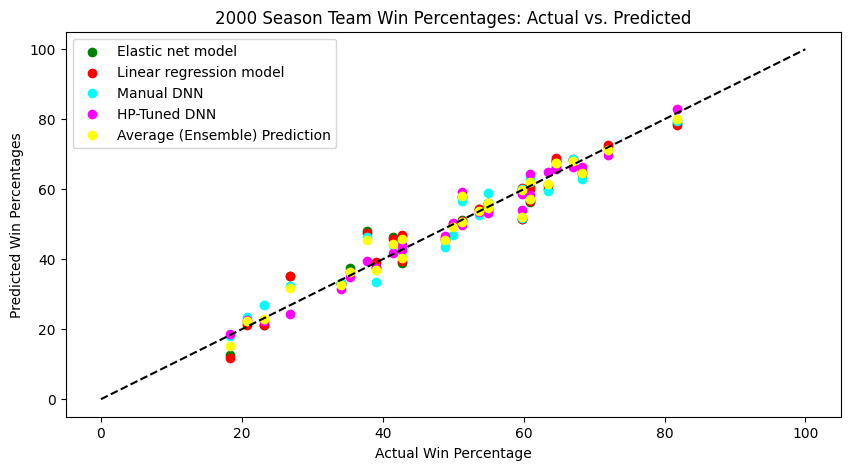

Elastic net model Error Mean: 0.24006533764208235 Error Standard Dev: 4.069338364851488
Linear regression model Error Mean: 0.2795658964289968 Error Standard Dev: 3.991590164472033
1/1 [==============================] - 0s 40ms/step
Manual DNN Error Mean: 0.08231544494628881 Error Standard Dev: 3.7255283829638843
4/4 [==============================] - 0s 6ms/step
HP-Tuned DNN Error Mean: -0.200706613474879 Error Standard Dev: 2.4329283315497188


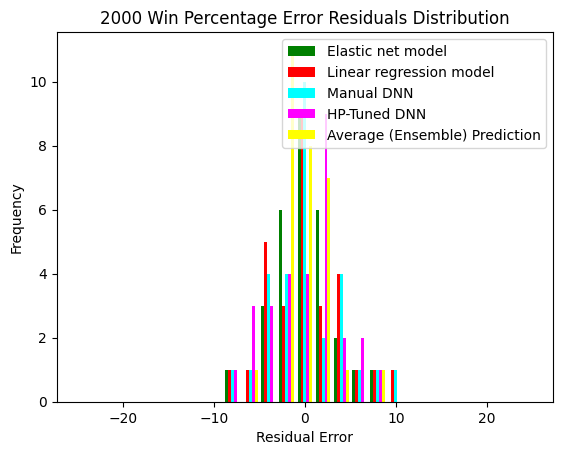

Elastic net model 2004 Actual vs. Predicted MSE: 9.658103213283072
Linear regression model 2004 Actual vs. Predicted MSE: 11.001768117992187
1/1 [==============================] - 0s 27ms/step
Manual DNN 2004 Actual vs. Predicted MSE: 14.957053521996729
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN 2004 Actual vs. Predicted MSE: 23.74826422676734
Average prediction MSE: 9.094540208828509


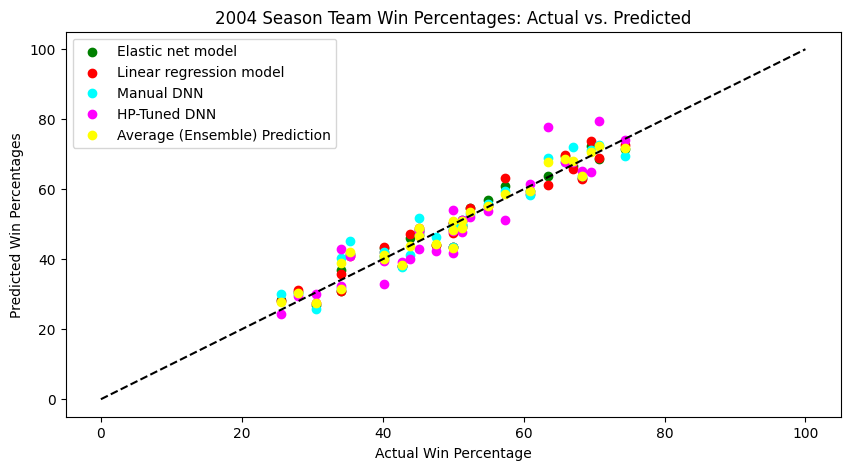

Elastic net model Error Mean: 0.15713671224761927 Error Standard Dev: 3.103773713875914
Linear regression model Error Mean: 0.11711774459091127 Error Standard Dev: 3.3148230046103704
1/1 [==============================] - 0s 29ms/step
Manual DNN Error Mean: 0.4302554294980797 Error Standard Dev: 3.8434273490446196
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN Error Mean: -0.18539724678828884 Error Standard Dev: 4.8696911696380365


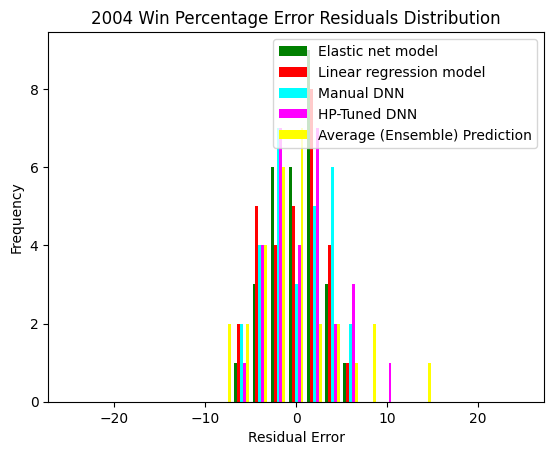

Elastic net model 2008 Actual vs. Predicted MSE: 13.674531310080596
Linear regression model 2008 Actual vs. Predicted MSE: 14.068617893002388
1/1 [==============================] - 0s 27ms/step
Manual DNN 2008 Actual vs. Predicted MSE: 16.415460093662496
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN 2008 Actual vs. Predicted MSE: 10.934496559061474
Average prediction MSE: 10.26781149740801


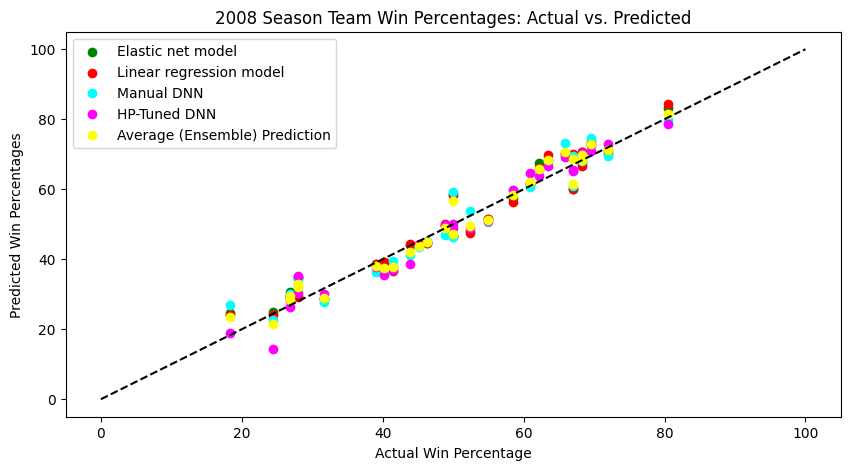

Elastic net model Error Mean: 0.8028787011677954 Error Standard Dev: 3.6096976467969872
Linear regression model Error Mean: 0.6982990998961939 Error Standard Dev: 3.68524032596065
1/1 [==============================] - 0s 26ms/step
Manual DNN Error Mean: 0.6598095575968418 Error Standard Dev: 3.997513157122357
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN Error Mean: -0.4217781066894538 Error Standard Dev: 3.2797255659245232


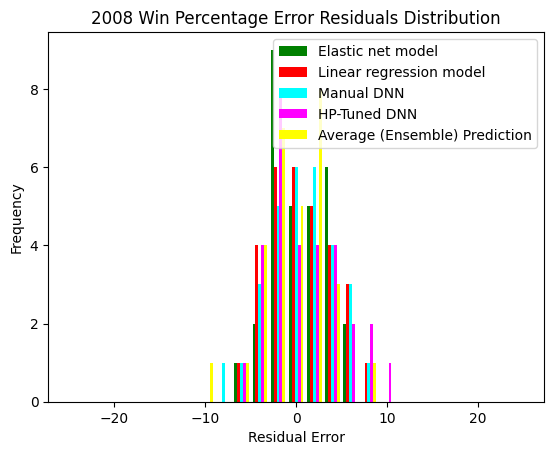

Elastic net model 2012 Actual vs. Predicted MSE: 16.081028413380626
Linear regression model 2012 Actual vs. Predicted MSE: 15.950830632909698
1/1 [==============================] - 0s 24ms/step
Manual DNN 2012 Actual vs. Predicted MSE: 24.297075183992344
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN 2012 Actual vs. Predicted MSE: 25.496339744827957
Average prediction MSE: 14.608928746638835


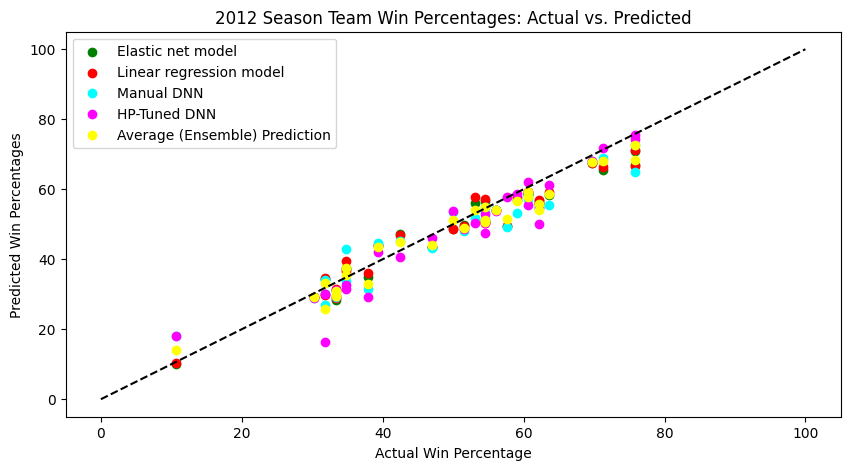

Elastic net model Error Mean: -2.0105559942354203 Error Standard Dev: 3.469681974968981
Linear regression model Error Mean: -1.7094153854876784 Error Standard Dev: 3.6095331654893705
1/1 [==============================] - 0s 31ms/step
Manual DNN Error Mean: -2.2095996220906584 Error Standard Dev: 4.406216596361232
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN Error Mean: -2.5657812118530274 Error Standard Dev: 4.348920155363853


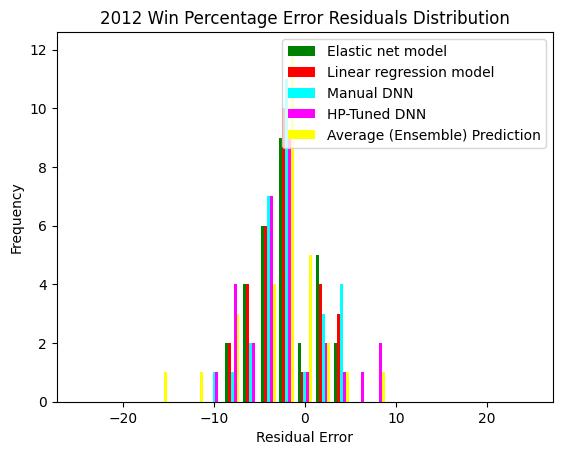

Elastic net model 2016 Actual vs. Predicted MSE: 13.399156478368003
Linear regression model 2016 Actual vs. Predicted MSE: 15.245535825122204
1/1 [==============================] - 0s 25ms/step
Manual DNN 2016 Actual vs. Predicted MSE: 17.76212756885221
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN 2016 Actual vs. Predicted MSE: 16.731120247517943
Average prediction MSE: 10.792090423935633


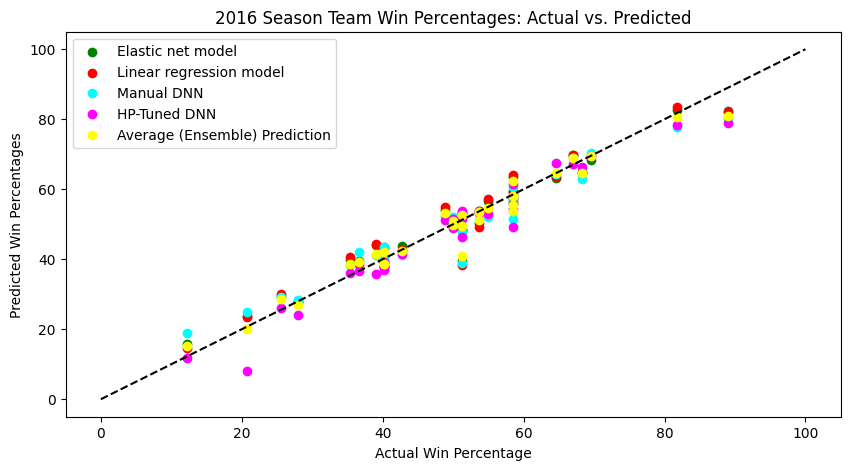

Elastic net model Error Mean: 0.25120364403195233 Error Standard Dev: 3.6518561318311913
Linear regression model Error Mean: 0.29384586049205846 Error Standard Dev: 3.893480504046975
1/1 [==============================] - 0s 25ms/step
Manual DNN Error Mean: -0.44105326334635453 Error Standard Dev: 4.191372041198889
4/4 [==============================] - 0s 4ms/step
HP-Tuned DNN Error Mean: -1.8115048726399743 Error Standard Dev: 3.6673655863466315


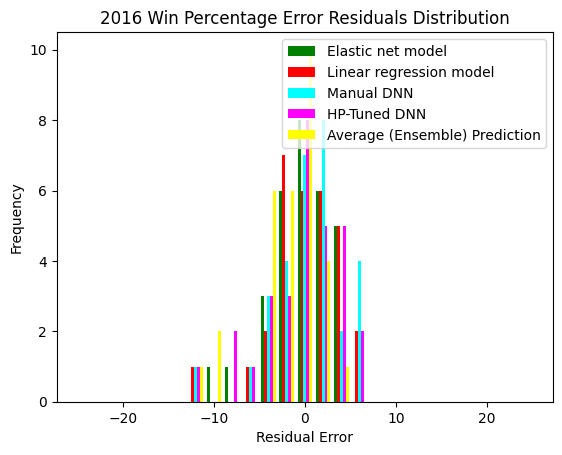

Elastic net model 2020 Actual vs. Predicted MSE: 22.842012243628936
Linear regression model 2020 Actual vs. Predicted MSE: 22.089408105904145
1/1 [==============================] - 0s 24ms/step
Manual DNN 2020 Actual vs. Predicted MSE: 30.590197212902478
4/4 [==============================] - 0s 5ms/step
HP-Tuned DNN 2020 Actual vs. Predicted MSE: 25.421498259141053
Average prediction MSE: 20.7804216127869


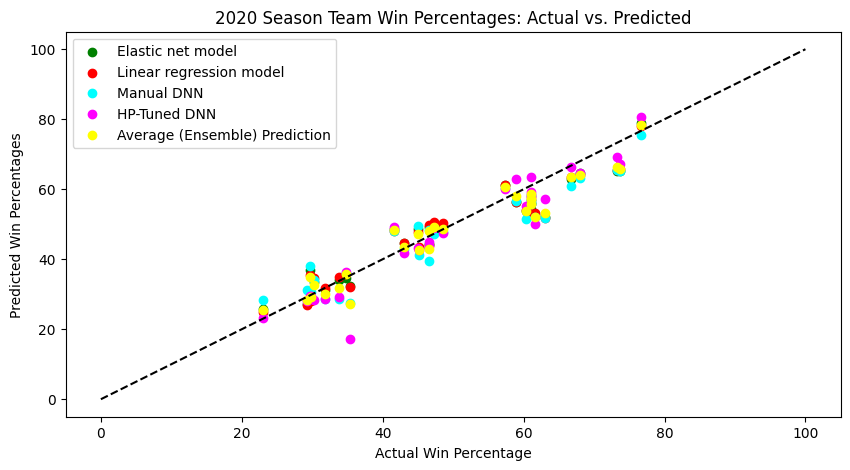

Elastic net model Error Mean: -1.3886107072106877 Error Standard Dev: 4.573157831023195
Linear regression model Error Mean: -1.3346907544857076 Error Standard Dev: 4.506440801319209
1/1 [==============================] - 0s 33ms/step
Manual DNN Error Mean: -2.1562450284792525 Error Standard Dev: 5.093211618425155
4/4 [==============================] - 0s 7ms/step
HP-Tuned DNN Error Mean: -1.9151805117759642 Error Standard Dev: 4.664073527127827


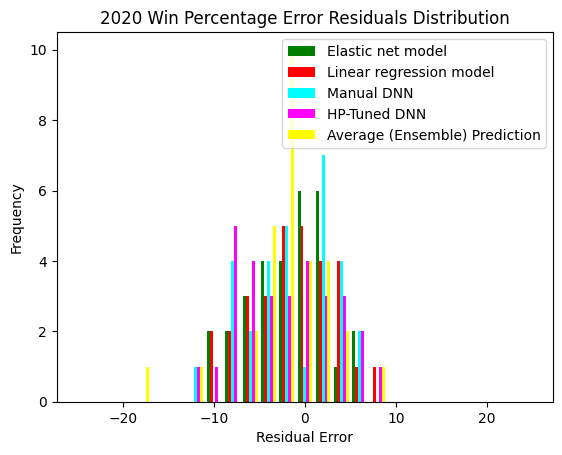

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

def plot_win_perc_residuals_predict_vs_actual(year, models):
    year_win, year_stats = top_from_team(year)  # Fetch actual win percentages and stats for the year

    plt.figure(figsize=(10, 5))  # Increase figure size for clarity

    # Plot actual win percentages once for comparison
    # plt.scatter(np.linspace(0, len(year_win), num=len(year_win)), year_win, color="skyblue", label="actual")

    colors = ['green', 'red', 'cyan', 'magenta', 'yellow', 'black']  # Extend as needed for models
    color_index = 0

    prediction_average = None
    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        if (prediction_average is None):
          prediction_average = year_predicted
        else:
          prediction_average += year_predicted
        mse = mean_squared_error(year_win, year_predicted)
        print(f'{model_name} {year} Actual vs. Predicted MSE: {mse}')

        # Plot predicted win percentages for each model
        plt.scatter(year_win, year_predicted, color=colors[color_index], label=model_name)
        color_index += 1

    prediction_average /= len(models.keys())
    prediction_mse = mean_squared_error(year_win, prediction_average)
    print(f'Average prediction MSE: {prediction_mse}')
    plt.scatter(year_win, prediction_average, color=colors[color_index], label='Average (Ensemble) Prediction')
    plt.legend(loc='best')
    plt.xlabel('Actual Win Percentage')
    plt.ylabel('Predicted Win Percentages')
    plt.title(f'{year} Season Team Win Percentages: Actual vs. Predicted')
    identity_line = np.linspace(0,100)
    plt.plot(identity_line, identity_line, color="black", linestyle="dashed")
    plt.show()

    all_residuals = [np.array(prediction_average) - np.array(year_win)]
    for model_name, model in models.items():
        year_predicted = model.predict(year_stats).flatten()
        error = np.array(year_predicted) - np.array(year_win)
        all_residuals.append(error)
        print(f'{model_name} Error Mean: {np.mean(error)} Error Standard Dev: {np.std(error)}')

    plt.hist(all_residuals, color=colors[:len(models.keys()) + 1], bins=25, range=[-25, 25], label=list(models.keys()) + ['Average (Ensemble) Prediction'])
    plt.legend(loc='best')
    plt.title(f'{year} Win Percentage Error Residuals Distribution')
    plt.xlabel('Residual Error')
    plt.ylabel('Frequency')
    plt.show()

def plot_win_perc_residuals_predict_vs_actual_plots(models):
    START_YEAR = 2000
    END_YEAR = 2020

    for i in range(START_YEAR, END_YEAR + 1, 4):
        plot_win_perc_residuals_predict_vs_actual(i, models)

plot_win_perc_residuals_predict_vs_actual_plots({ 'Elastic net model': elastic_net_regressor, 'Linear regression model': regressor, 'Manual DNN': manual_model, 'HP-Tuned DNN': best_model })


# Fun Exploratory: Predicting This Year's Teams Using Ensemble Learning

In [ ]:
team_abbrev_file = pd.read_csv("data/Team Abbrev.csv")
team_abbrev_file = team_abbrev_file[team_abbrev_file['season'] == 2024]
team_abbrev = team_abbrev_file[['team', 'abbreviation']].to_numpy()

models = {
    'Elastic net model': elastic_net_regressor,
    'Linear regression model': regressor,
    'Manual DNN': manual_model,
    'HP-Tuned DNN': best_model
}

for i in range(team_abbrev.shape[0]):
    team_win_perc_actual, team_stats = top_from_team(2024, True, team_abbrev[i][1])
    team_win_perc_predicted = []

    for model_name, model in models.items():
        prediction = model.predict(team_stats)[0]
        if (hasattr(prediction, "__len__")):
          prediction = prediction[0]
        team_win_perc_predicted.append(prediction)

    print(team_win_perc_predicted)
    team_win_perc_predicted_avg = np.mean(team_win_perc_predicted)

    print(f"{team_abbrev[i][0]} Actual win percentage: {team_win_perc_actual[0]}. Predicted win percentage: {team_win_perc_predicted_avg} [{team_win_perc_predicted_avg - team_win_perc_actual[0]}]")

1/1 [==============================] - 0s 39ms/step
[42.02401548460416, 43.11730003188939, 39.29869, 34.178154]
Atlanta Hawks Actual win percentage: 43.63636363636363. Predicted win percentage: 39.654540076022805 [-3.9818235603408283]
1/1 [==============================] - 0s 28ms/step
[69.7968874235642, 69.50207036172395, 66.0593, 72.48032]
Boston Celtics Actual win percentage: 78.18181818181819. Predicted win percentage: 69.45964621512087 [-8.722171966697317]
1/1 [==============================] - 0s 25ms/step
[38.1928079870988, 39.62062714901403, 36.074665, 31.436691]
Brooklyn Nets Actual win percentage: 38.888888888888886. Predicted win percentage: 36.33119787246815 [-2.5576910164207334]
1/1 [==============================] - 0s 25ms/step
[26.65448779056517, 24.006126051602124, 32.864002, 25.0993]
Charlotte Hornets Actual win percentage: 24.074074074074073. Predicted win percentage: 27.155979113617995 [3.0819050395439227]
1/1 [==============================] - 0s 24ms/step
[44.8899

#4. Where does your model fit in the fitting graph, how does it compare to your first model?

## Note: we will discuss our multiple models (which we consider technically as one) here.

Based on the performance metrics we obtained, it's clear that our new models have significantly improved upon our initial linear regression model. Let's discuss the fitting graph description for each of the new models we developed:

Elastic Net Model:
Our Elastic Net model has shown a notable improvement in performance compared to our linear regression model. The training MSE has decreased to approximately 17.38, while the testing MSE is around 19.92. This indicates a better fit to the data compared to our initial model. The training and testing errors are relatively close, suggesting that the model is not overfitting or underfitting. The Elastic Net regularization we applied has effectively balanced the model's complexity and generalization ability. The R^2 values for both training and testing are above 0.90, indicating a strong correlation between the predicted and actual win percentages.

Hyperparameter-Tuned DNN Model:
Our hyperparameter-tuned DNN model has shown remarkable performance. The training MSE has significantly decreased to approximately 8.98, indicating a much better fit to the training data. However, the testing MSE is higher at around 41.25. This discrepancy between training and testing errors suggests that the model might be overfitting to some extent. The hyperparameter tuning process we conducted has likely resulted in a complex model that performs exceptionally well on the training data but struggles to generalize to unseen data. The R^2 value for training is impressively high at 0.96, while the testing R^2 is lower at 0.81. This further supports the notion of overfitting.

Manually Tuned DNN Model:
Our manually tuned DNN model has also shown improvement compared to our linear regression model. The training MSE is approximately 19.84, while the testing MSE is around 24.06. These errors are lower than our initial model but higher than our Elastic Net model. The manually tuned DNN model seems to have a reasonable balance between fitting the training data and generalizing to unseen data. The R^2 values for both training and testing are above 0.88, indicating a good correlation between the predicted and actual win percentages.

Overall, our Elastic Net model appears to have the best balance between performance and generalization. It has significantly reduced the error compared to our linear regression model while maintaining a good fit to both training and testing data. Our hyperparameter-tuned DNN model has achieved the lowest training error but seems to be overfitting, as evidenced by the higher testing error. Our manually tuned DNN model has shown improvement but falls short of the Elastic Net model's performance.

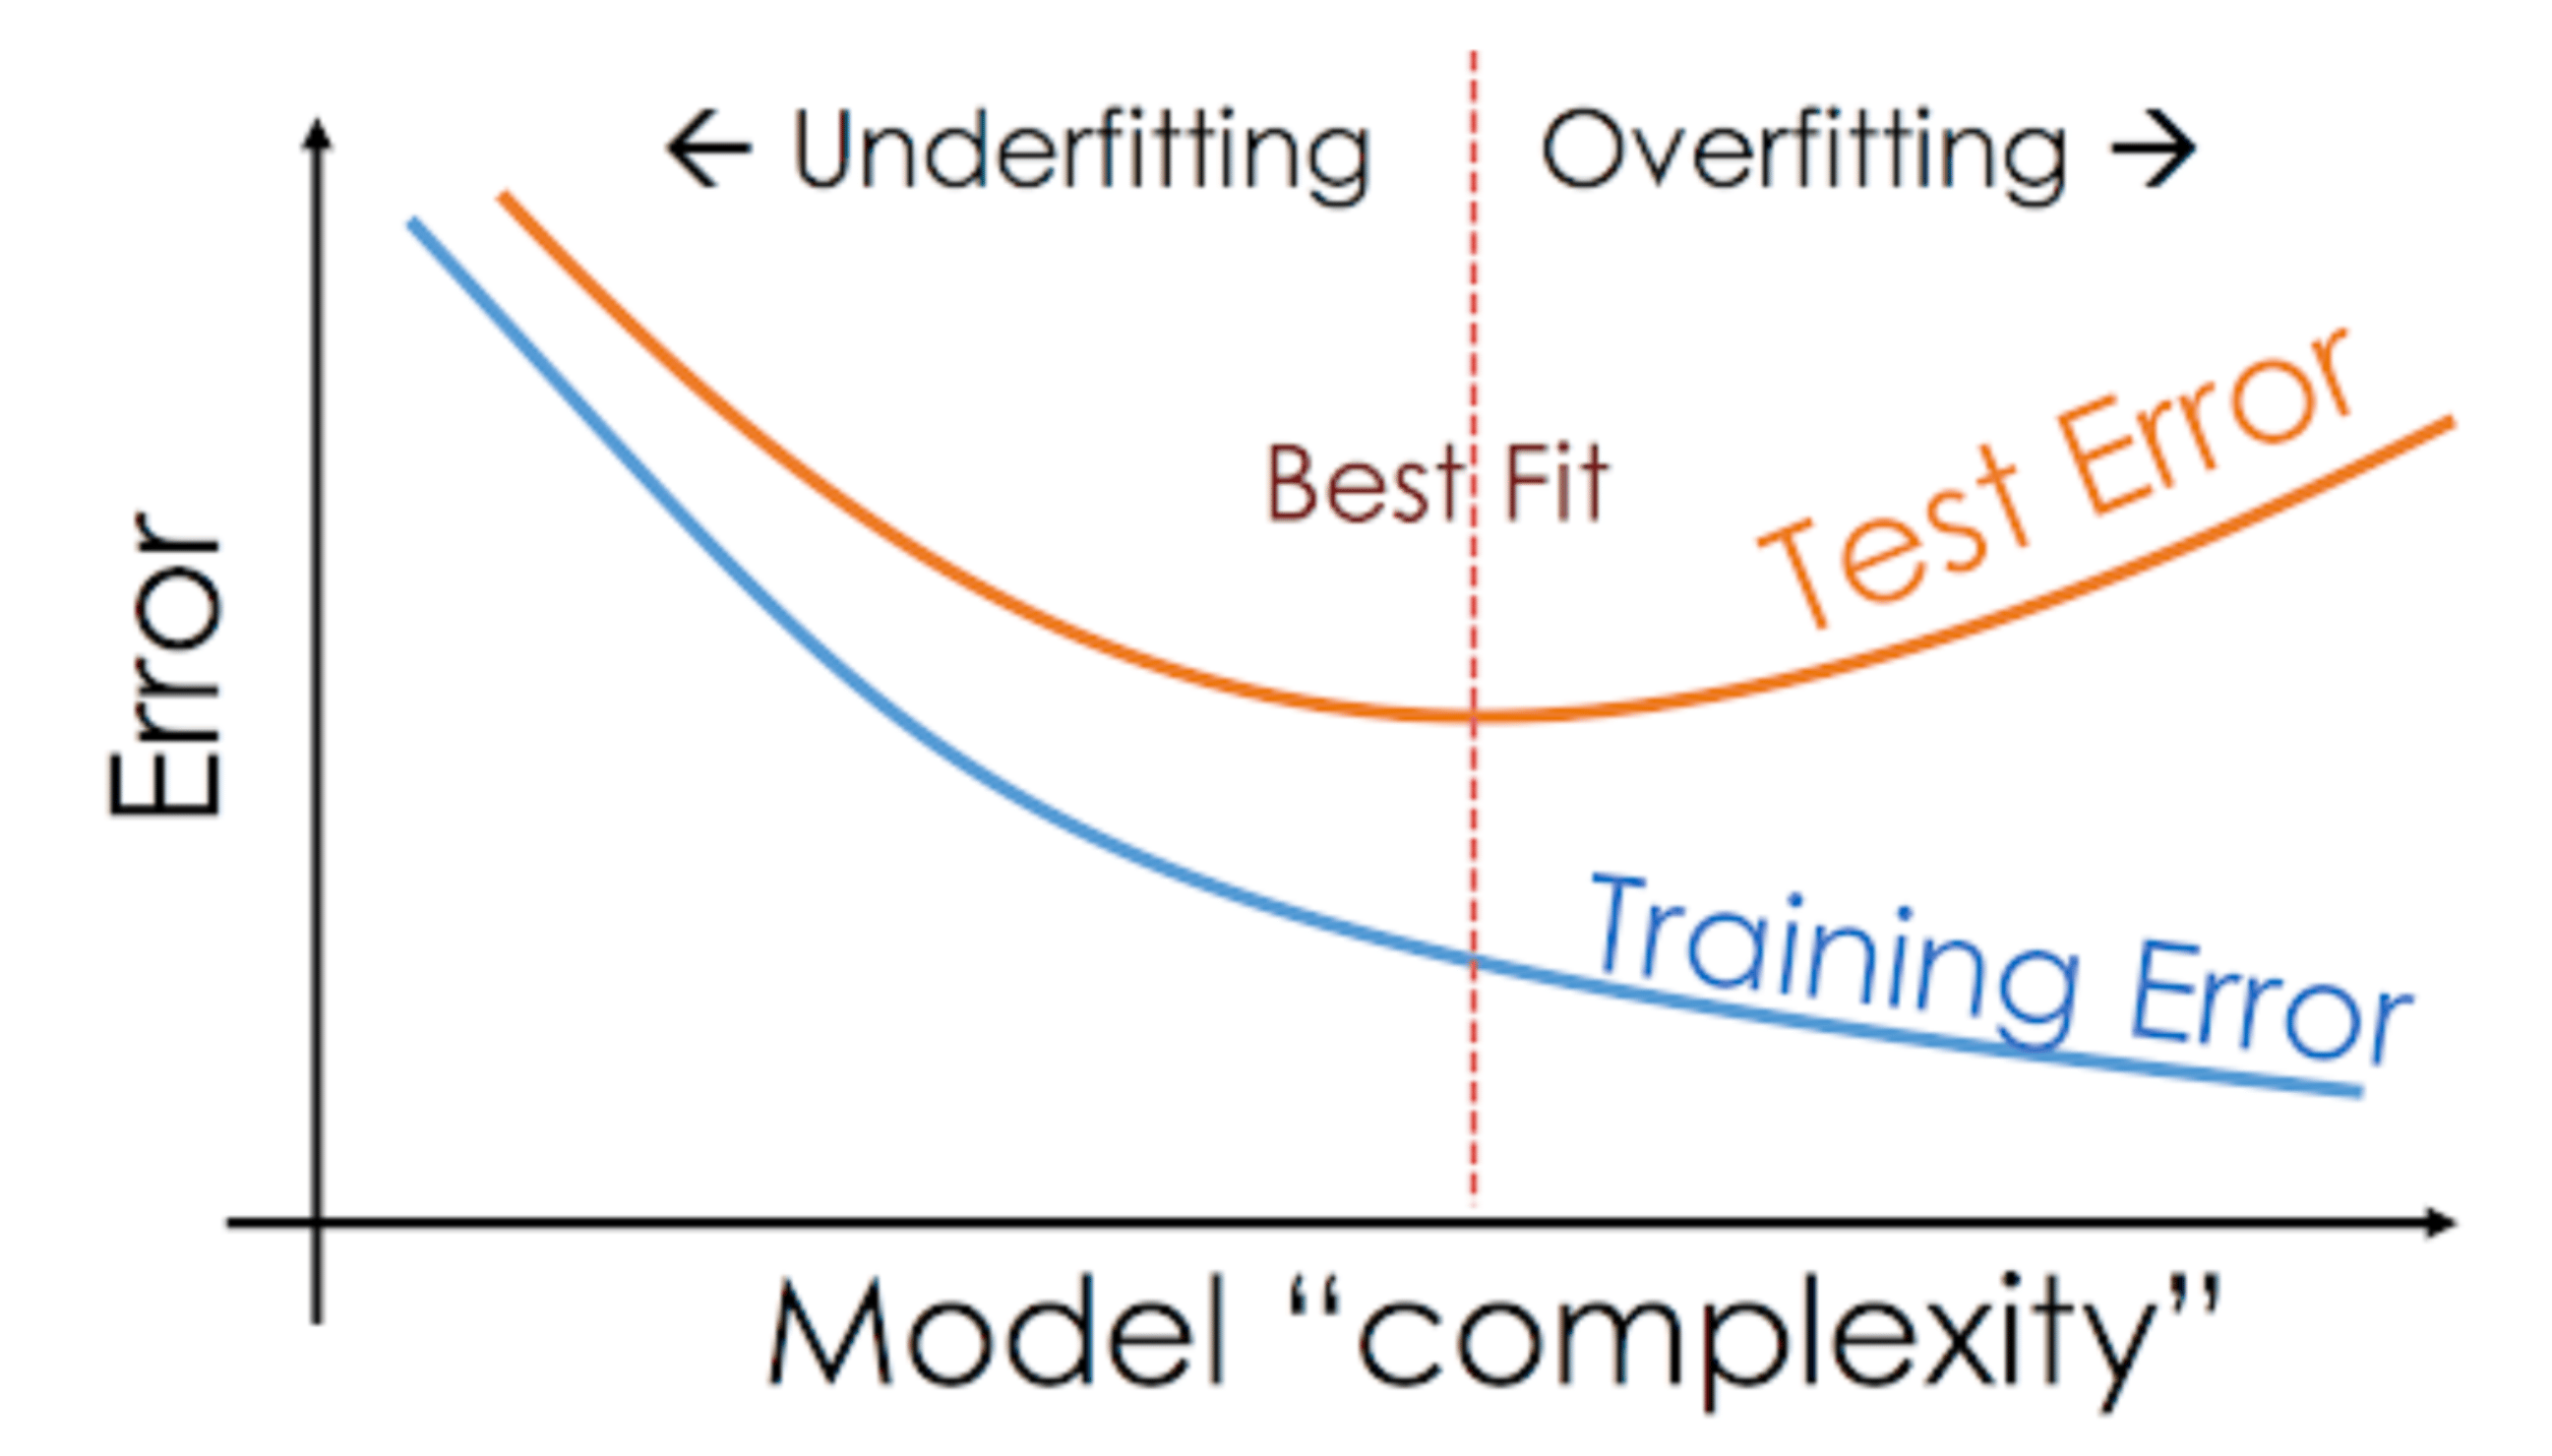

#5. Did you perform hyper parameter tuning? K-fold Cross validation? Feature expansion? What were the results?

Yes, we performed hyperparameter tuning, cross-validation, and feature expansion for both our Elastic Net model and Deep Neural Network (DNN) model.

For the Elastic Net model, we used GridSearchCV to search for the best hyperparameters. We defined a parameter grid with different values for the 'alpha' (regularization strength) and 'l1_ratio' (mix ratio between Lasso and Ridge) hyperparameters. We used 5-fold cross-validation (cv=5) to evaluate the model's performance for each combination of hyperparameters. GridSearchCV then selected the best combination of hyperparameters based on the model's performance.

Regarding feature expansion, we extended our feature set to include additional player statistics such as 'ts_percent', 'experience', 'x3p_ar', 'per', 'ws_48', 'usg_percent', 'bpm', and 'vorp'. This expanded feature set provides a more comprehensive representation of player performance compared to our previous observations, which only considered 'per', 'ws_48', 'usg_percent', 'bpm', and 'vorp'. Additionally, we now consider the top 10 players from each roster instead of the top 8 players, allowing for a broader representation of team talent.

For the DNN model, we also used GridSearchCV for hyperparameter tuning. We defined a parameter grid that included different values for the number of hidden layers, initial units, activation function, and batch size. We used KFold cross-validation with 5 splits (n_splits=5) and shuffled the data (shuffle=True) for each fold. GridSearchCV searched for the best combination of hyperparameters based on the negative mean squared error (neg_mean_squared_error) as the scoring metric.

After finding the best hyperparameters for each model, we trained the models using the best parameters. For the DNN model, we also incorporated early stopping (EarlyStopping) to prevent overfitting. Early stopping monitored the validation mean squared error (val_mse) and stopped training if there was no improvement after 25 epochs (patience=25), restoring the best weights.

The results of hyperparameter tuning showed that the best parameters for the Elastic Net model were found through GridSearchCV, in this case values of "elasticnet__alpha': 0.004, 'elasticnet__l1_ratio': 0.9". Similarly, for the DNN model, the best parameters and the corresponding best score (negative mean squared error) were printed: "{'batch_size': 8, 'model__activation': 'relu', 'model__hidden_layers': 4, 'model__initial_units': 810} and Best score:  58.875539655649916". **We observe that although the elastic net model hyperparameter tuning resulted in an improved model from the simpler linear regression model without regularization, the DNN model had actually worse performance than the manually tuned values that our team found ourselves through trial and error.**

The expanded feature set and the inclusion of the top 10 players from each roster likely contributed to improved model performance by capturing a more comprehensive representation of team and player characteristics. The additional features provide a richer set of information for the models to learn from, potentially leading to more accurate predictions.

#6. What is the plan for the next model you are thinking of and why?


Based on the performance of our current models, we believe that the next step in improving our predictive capabilities is to explore more advanced modeling techniques. While our Elastic Net model has shown promising results, we think that there is still room for improvement in terms of reducing the error and capturing more complex relationships within the data.

Our plan for the next model is to investigate the use of Support Vector Machines (SVMs) with non-linear kernels, specifically the Radial Basis Function (RBF) kernel. We have several reasons for considering this approach:

Non-linear Relationships: SVMs with RBF kernels have the ability to capture non-linear relationships between the features and the target variable. By mapping the input data into a higher-dimensional space, SVMs can find complex decision boundaries that separate the different classes or predict continuous values.

Regularization: SVMs have built-in regularization through the C parameter, which controls the trade-off between fitting the training data well and allowing some misclassifications. This regularization can help prevent overfitting and improve the model's generalization ability.

Hyperparameter Tuning: SVMs with RBF kernels have two main hyperparameters: C (regularization parameter) and gamma (kernel coefficient). We plan to conduct hyperparameter tuning using techniques like grid search or random search to find the optimal combination of these hyperparameters that minimizes the error metrics.

To implement this plan, we will start by preprocessing our data, ensuring that it is scaled and normalized appropriately for SVM training. We will then split the data into training and testing sets, allowing us to evaluate the model's performance on unseen data. We will utilize cross-validation techniques to assess the model's robustness and generalization ability.

After training the SVM model with different hyperparameter configurations, we will evaluate its performance using various metrics such as Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2). We will compare these metrics with our previous models to determine if the SVM model provides a significant improvement.

In conclusion, our second set of models, which included the Elastic Net, hyperparameter-tuned DNN, and manually tuned DNN, showed significant improvements over our initial linear regression model. The Elastic Net model demonstrated the best balance between performance and generalization, with lower training and testing errors compared to the linear regression model. It effectively managed model complexity and achieved R^2 values above 0.90, indicating a strong correlation between predicted and actual win percentages.

The hyperparameter-tuned DNN model achieved the lowest training error, showcasing its ability to fit the training data exceptionally well. However, it exhibited signs of overfitting, as evidenced by the higher testing error compared to the Elastic Net model. This suggests that the model's complexity may have hindered its generalization ability to unseen data.

The manually tuned DNN model also demonstrated improvement over the linear regression model, with lower training and testing errors. While it found a reasonable balance between fitting the training data and generalizing to unseen data, it did not outperform the Elastic Net model in terms of overall performance.

To further improve our models, we can (continue to) explore several avenues:

Regularization Techniques: Investigate different regularization techniques for the DNN models, such as L1 and L2 regularization, dropout, or early stopping, to mitigate overfitting and enhance generalization.

Hyperparameter Fine-tuning: Conduct more extensive hyperparameter tuning for the Elastic Net and DNN models to find the optimal combination of hyperparameters that minimizes the error metrics.

Feature Selection and Engineering: Analyze feature importance and consider selecting the most relevant features or engineering new features based on domain knowledge to improve the models' predictive power.

Data Augmentation: Collect more diverse and representative data to increase the models' exposure to different scenarios and improve their generalization ability.

Ensemble Methods: Explore ensemble techniques, such as bagging or boosting, to combine multiple models and leverage their collective knowledge for improved predictions.

Compared to our first linear regression model, the second set of models demonstrated significant improvements in performance. The Elastic Net model, in particular, achieved a better balance between bias and variance, capturing more complex relationships in the data while avoiding overfitting. The DNN models, although showing promise, required careful hyperparameter tuning to strike the right balance between fitting the training data and generalizing to unseen data.

Overall, the second set of models, especially the Elastic Net, provided a more accurate and reliable approach to predicting win percentages compared to the linear regression model. By leveraging regularization, hyperparameter tuning, and considering feature importance, we were able to develop models that better captured the underlying patterns in the data and improved our predictive capabilities.